## Ecommerce Trade Sales

In [114]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytrends.request import TrendReq
from statsmodels.tsa.stattools import kpss, adfuller

### Reading and Filtering data

In [2]:
data = pd.read_csv('../../data/retailEcommercesales/retailEcommerceSales.csv',sep=',')
data.head(2)

,REF_DATE,GEO,DGUID,Sales,UOM,UOM_ID,SCALAR_FACTOR,SCALAR_ID,VECTOR,COORDINATE,VALUE,STATUS,SYMBOL,TERMINATED,DECIMALS
0,2016-01,Canada,2016A000011124,"Retail trade, unadjusted\n [44-453]",Dollars,81,thousands,3,v108795018,1.1,37415147,A,NaN,NaN,0
1,2016-01,Canada,2016A000011124,"Electronic shopping and mail-order houses, una...",Dollars,81,thousands,3,v108795019,1.2,679612,B,NaN,NaN,0


In [3]:
# data filter
retailEcommercesales = data[~data["Sales"].str.contains('unadjusted')]
retailEcommercesales = retailEcommercesales.filter(['REF_DATE','VALUE'])

# rename columns
retailEcommercesales = retailEcommercesales.rename(columns = {'REF_DATE': 'Date', 'VALUE': 'Ecommerce_sales'})

In [4]:
retailEcommercesales.head(2)

,Date,Ecommerce_sales
3,2016-01,977198
7,2016-02,1006610


### Time series plot of Ecommerce trade sales

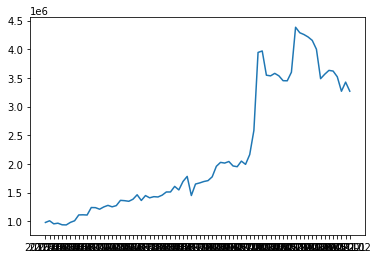

In [5]:
retailEcommercesales_dup = retailEcommercesales.copy()
retailEcommercesales_dup.index=retailEcommercesales_dup['Date']
plt.plot(retailEcommercesales_dup['Ecommerce_sales'])
plt.show()

In [15]:
retailEcommercesales_ts = retailEcommercesales.set_index('Date')

In [29]:
retailEcommercesales_ts.head(2)

,Ecommerce_sales,Growth_rate
Date,,
2016-01,977198,0.000000
2016-02,1006610,0.030098


In [17]:
retailEcommercesales_ts['Growth_rate'] = retailEcommercesales_ts.pct_change()

In [28]:
retailEcommercesales_ts['Growth_rate'][0] = '0'

C:\Users\hp\AppData\Local\Temp\ipykernel_9496\1695327831.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  retailEcommercesales_ts['Growth_rate'][0] = '0'


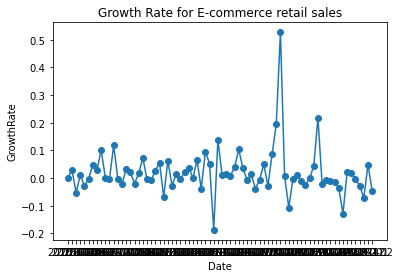

<Figure size 1600x500 with 0 Axes>

In [169]:
# Plot
plt.plot(retailEcommercesales_ts['Growth_rate'], marker='o')

# Labelling 
plt.xlabel("Date")
plt.ylabel("GrowthRate")
plt.title("Growth Rate for E-commerce retail sales")
plt.figure(figsize=(16,5), dpi=100)

# Display
plt.show()

### Stationarity testing

**KPSS Test**

In [165]:
def kpss_test(timeseries):
    print("Result from the KPSS Stationarity Test: ")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    #print(kpss_output)
    if kpsstest[1] > 0.05:
        print("    The series is stationary with 5% level of significant")
    else:
        print("    The series is not stationary with 5% level of significant")

In [74]:
kpss_test(retailEcommercesales_ts['Growth_rate'])

Result from the ADF Stationarity Test: 
    The series is stationary


C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


**Interpretation:**

The test indicates that the series is stationary as p-value is greater than 5% level of significance implying we fail to reject the null hypothesis.

**ADF Test**

In [166]:
def adf_test(timeseries):
    print("Result from the ADF Stationarity Test: ")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    
    if dftest[1] < 0.05 :
        print("    The series is Stationary with 5% level of significant")
    else:
        print("    The series is Non-Stationary with 5% level of significant")

In [72]:
adf_test(retailEcommercesales_ts['Growth_rate'])

Result from the ADF Stationarity Test: 
    The Series is Stationary


**Interpretation:**

The test indicates that the series is stationary as p-value is smaller than 5% level of significance implying we reject the null hypothesis.

### Keywords extraction using PyTrend

In [127]:
pytrends = TrendReq(hl='en-us', backoff_factor=0.1)

def ecommerce_trend(keywords=[''],category='340'):
    
    """ 
    Function for getting trends for selected keywords
        
        arguments: 
        
            Keywords: List of String ser
            category: String: stores the code for category
        
        returns: Related queries and related topics from google trend as a data frame
    """
    kw_list = keywords
    cat=category
    timeframe = '2004-01-01 2022-05-11'
    geo='CA'
    
    pytrends.build_payload(kw_list, cat, timeframe, geo, gprop='')
    data = pytrends.interest_over_time()
    queries = pytrends.related_queries()
    topics = pytrends.related_topics()
    
    return data , queries, topics

### Normalize a time series

In [173]:
PayPal_ts, queries, topics = ecommerce_trend(keywords=['PayPal'],category='340')

In [180]:
def normalization(x):
    x_min,x_max = min(x) , max(x)
    for i in range(len(x)):
        value = (x[i] - x_min)/(x_max - x_min)
        return value

In [181]:
x=[1,2,3,4]
normalization(x)

0.0

**Dictionary of keywords**

In [128]:
category_ts, queries, topics = ecommerce_trend(keywords=[''],category='340')  #function calling

keyword_query_frame= dict()  #Dictionary for queries
keyword_topic_frame= dict()  #Dictionary for topic

# keywords from queries
keyword_rising_query = queries['']['rising']['query'].unique().tolist() 
keyword_top_query = queries['']['top']['query'].unique().tolist()

# keywords from topic
keyword_rising_topics = topics['']['rising']['topic_title'].unique().tolist() 
keyword_top_topics = topics['']['top']['topic_title'].unique().tolist()

In [129]:
# keywords dict

keyword_query_frame['340'] = keyword_top_query
keyword_topic_frame['340'] = keyword_top_topics

In [130]:
keyword_topic_frame

{'340': ['PayPal',
  'Payment',
  'Money',
  'Canada',
  'Shopify',
  'Number',
  'Western Union',
  'Bank',
  'MoneyGram International Inc',
  'PayPal CA ltd',
  'Account',
  'Invoice',
  'Moneris',
  'Credit',
  'TD Canada Trust',
  'Credit card',
  'E-commerce',
  'Cheque',
  'Google',
  'Electronic funds transfer',
  'Routing number']}

### Category Time Series

In [99]:
category_ts = category_ts.drop(columns='isPartial')
category_ts['Growth_rate'] = category_ts.pct_change()
category_ts['Growth_rate'][0] = '0'

In [103]:
category_ts.head(2)

,,Growth_rate
date,,
2004-01-01,90,0.000000
2004-02-01,93,0.033333


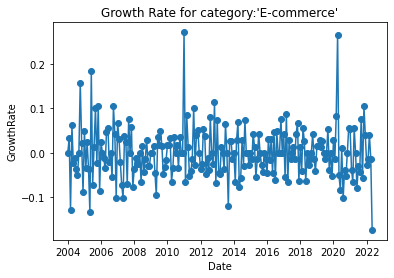

<Figure size 1600x500 with 0 Axes>

In [168]:
# Plot
plt.plot(category_ts['Growth_rate'], marker='o')

# Labelling 
plt.xlabel("Date")
plt.ylabel("GrowthRate")
plt.title("Growth Rate for category:'E-commerce'")
plt.figure(figsize=(16,5), dpi=100)


# Display
plt.show()

**Category Stationarity Test**

In [106]:
kpss_test(category_ts['Growth_rate'])

Result from the ADF Stationarity Test: 
    The series is stationary


C:\Users\hp\miniconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


In [107]:
adf_test(category_ts['Growth_rate'])

Result from the ADF Stationarity Test: 
    The Series is Stationary


### Keywords Time Series

In [131]:
keyword_topic_frame

{'340': ['PayPal',
  'Payment',
  'Money',
  'Canada',
  'Shopify',
  'Number',
  'Western Union',
  'Bank',
  'MoneyGram International Inc',
  'PayPal CA ltd',
  'Account',
  'Invoice',
  'Moneris',
  'Credit',
  'TD Canada Trust',
  'Credit card',
  'E-commerce',
  'Cheque',
  'Google',
  'Electronic funds transfer',
  'Routing number']}

In [172]:
for key, value in keyword_topic_frame.items():
    for j in range(len(value)):
        keyword=[str(value[j])]
        topicKeywords_ts, queries, topics = ecommerce_trend(keywords=keyword,category=str(key))  #function calling
        if len(topicKeywords_ts) != 0:
            topicKeywords_ts = topicKeywords_ts.drop(columns='isPartial')
            topicKeywords_ts['Growth_rate'] = topicKeywords_ts[keyword].pct_change()
            topicKeywords_ts['Growth_rate'][0] = '0'
            #if keyword == "Shopify":
            print(topicKeywords_ts)
            #print(">>>>>>>>>>>>>>>>>>>", keyword, ">>>>>>>>>>>>>>>>>>>>>>>" )
            #try:
             #   adf_test(topicKeywords_ts['Growth_rate'])
            #except:
             #   print("+++++ ERROR ++++++")
            #try:
             #   kpss_test(topicKeywords_ts['Growth_rate'])
            #except:
             #   print("+++++ ERROR ++++++")

C:\Users\hp\AppData\Local\Temp\ipykernel_9496\704214702.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topicKeywords_ts['Growth_rate'][0] = '0'


            PayPal  Growth_rate
date                           
2004-01-01      53     0.000000
2004-02-01      48    -0.094340
2004-03-01      41    -0.145833
2004-04-01      44     0.073171
2004-05-01      48     0.090909
...            ...          ...
2022-01-01      53    -0.101695
2022-02-01      51    -0.037736
2022-03-01      49    -0.039216
2022-04-01      49     0.000000
2022-05-01      45    -0.081633

[221 rows x 2 columns]


C:\Users\hp\AppData\Local\Temp\ipykernel_9496\704214702.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topicKeywords_ts['Growth_rate'][0] = '0'


            Payment  Growth_rate
date                            
2004-01-01       21     0.000000
2004-02-01       32     0.523810
2004-03-01       28    -0.125000
2004-04-01       26    -0.071429
2004-05-01       18    -0.307692
...             ...          ...
2022-01-01       79    -0.012500
2022-02-01       77    -0.025316
2022-03-01       76    -0.012987
2022-04-01       82     0.078947
2022-05-01       82     0.000000

[221 rows x 2 columns]


C:\Users\hp\AppData\Local\Temp\ipykernel_9496\704214702.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topicKeywords_ts['Growth_rate'][0] = '0'


            Money  Growth_rate
date                          
2004-01-01     46     0.000000
2004-02-01     38    -0.173913
2004-03-01     58     0.526316
2004-04-01     50    -0.137931
2004-05-01     37    -0.260000
...           ...          ...
2022-01-01     82     0.012346
2022-02-01     81    -0.012195
2022-03-01     87     0.074074
2022-04-01     83    -0.045977
2022-05-01     78    -0.060241

[221 rows x 2 columns]


C:\Users\hp\AppData\Local\Temp\ipykernel_9496\704214702.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topicKeywords_ts['Growth_rate'][0] = '0'


            Canada  Growth_rate
date                           
2004-01-01      27     0.000000
2004-02-01      26    -0.037037
2004-03-01      28     0.076923
2004-04-01      25    -0.107143
2004-05-01      22    -0.120000
...            ...          ...
2022-01-01      72    -0.052632
2022-02-01      70    -0.027778
2022-03-01      84     0.200000
2022-04-01      81    -0.035714
2022-05-01      78    -0.037037

[221 rows x 2 columns]


C:\Users\hp\AppData\Local\Temp\ipykernel_9496\704214702.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topicKeywords_ts['Growth_rate'][0] = '0'


            Shopify  Growth_rate
date                            
2004-01-01        0     0.000000
2004-02-01        0          NaN
2004-03-01        0          NaN
2004-04-01        0          NaN
2004-05-01        0          NaN
...             ...          ...
2022-01-01       49     0.166667
2022-02-01       48    -0.020408
2022-03-01       47    -0.020833
2022-04-01       43    -0.085106
2022-05-01       39    -0.093023

[221 rows x 2 columns]


C:\Users\hp\AppData\Local\Temp\ipykernel_9496\704214702.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topicKeywords_ts['Growth_rate'][0] = '0'


            Number  Growth_rate
date                           
2004-01-01      17     0.000000
2004-02-01       6    -0.647059
2004-03-01      26     3.333333
2004-04-01      15    -0.423077
2004-05-01      10    -0.333333
...            ...          ...
2022-01-01      64     0.015873
2022-02-01      64     0.000000
2022-03-01      69     0.078125
2022-04-01      67    -0.028986
2022-05-01      74     0.104478

[221 rows x 2 columns]


C:\Users\hp\AppData\Local\Temp\ipykernel_9496\704214702.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topicKeywords_ts['Growth_rate'][0] = '0'


            Western Union  Growth_rate
date                                  
2004-01-01             39     0.000000
2004-02-01             45     0.153846
2004-03-01             22    -0.511111
2004-04-01             48     1.181818
2004-05-01             37    -0.229167
...                   ...          ...
2022-01-01             70    -0.239130
2022-02-01             70     0.000000
2022-03-01             69    -0.014286
2022-04-01             79     0.144928
2022-05-01             68    -0.139241

[221 rows x 2 columns]


C:\Users\hp\AppData\Local\Temp\ipykernel_9496\704214702.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topicKeywords_ts['Growth_rate'][0] = '0'


            Bank  Growth_rate
date                         
2004-01-01    14     0.000000
2004-02-01    43     2.071429
2004-03-01    20    -0.534884
2004-04-01    25     0.250000
2004-05-01    18    -0.280000
...          ...          ...
2022-01-01    77     0.069444
2022-02-01    79     0.025974
2022-03-01    73    -0.075949
2022-04-01    73     0.000000
2022-05-01    68    -0.068493

[221 rows x 2 columns]


C:\Users\hp\AppData\Local\Temp\ipykernel_9496\704214702.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topicKeywords_ts['Growth_rate'][0] = '0'


            Account  Growth_rate
date                            
2004-01-01       16     0.000000
2004-02-01       19     0.187500
2004-03-01       23     0.210526
2004-04-01       25     0.086957
2004-05-01       20    -0.200000
...             ...          ...
2022-01-01       66     0.081967
2022-02-01       58    -0.121212
2022-03-01       63     0.086207
2022-04-01       58    -0.079365
2022-05-01       66     0.137931

[221 rows x 2 columns]


C:\Users\hp\AppData\Local\Temp\ipykernel_9496\704214702.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topicKeywords_ts['Growth_rate'][0] = '0'


            Invoice  Growth_rate
date                            
2004-01-01        0     0.000000
2004-02-01        0          NaN
2004-03-01        0          NaN
2004-04-01        0          NaN
2004-05-01        0          NaN
...             ...          ...
2022-01-01       50    -0.152542
2022-02-01       31    -0.380000
2022-03-01       84     1.709677
2022-04-01       49    -0.416667
2022-05-01       67     0.367347

[221 rows x 2 columns]


C:\Users\hp\AppData\Local\Temp\ipykernel_9496\704214702.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topicKeywords_ts['Growth_rate'][0] = '0'


            Moneris  Growth_rate
date                            
2004-01-01       23     0.000000
2004-02-01       53     1.304348
2004-03-01       36    -0.320755
2004-04-01       64     0.777778
2004-05-01       36    -0.437500
...             ...          ...
2022-01-01       64     0.084746
2022-02-01       67     0.046875
2022-03-01       73     0.089552
2022-04-01       68    -0.068493
2022-05-01       87     0.279412

[221 rows x 2 columns]


C:\Users\hp\AppData\Local\Temp\ipykernel_9496\704214702.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topicKeywords_ts['Growth_rate'][0] = '0'


            Credit  Growth_rate
date                           
2004-01-01      38     0.000000
2004-02-01      55     0.447368
2004-03-01      75     0.363636
2004-04-01      44    -0.413333
2004-05-01      29    -0.340909
...            ...          ...
2022-01-01      80    -0.047619
2022-02-01      74    -0.075000
2022-03-01      76     0.027027
2022-04-01      83     0.092105
2022-05-01      91     0.096386

[221 rows x 2 columns]


C:\Users\hp\AppData\Local\Temp\ipykernel_9496\704214702.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topicKeywords_ts['Growth_rate'][0] = '0'


            TD Canada Trust  Growth_rate
date                                    
2004-01-01                0     0.000000
2004-02-01               50          inf
2004-03-01               61     0.220000
2004-04-01               25    -0.590164
2004-05-01               22    -0.120000
...                     ...          ...
2022-01-01               32    -0.157895
2022-02-01               37     0.156250
2022-03-01               30    -0.189189
2022-04-01               48     0.600000
2022-05-01               34    -0.291667

[221 rows x 2 columns]


C:\Users\hp\AppData\Local\Temp\ipykernel_9496\704214702.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topicKeywords_ts['Growth_rate'][0] = '0'


            Credit card  Growth_rate
date                                
2004-01-01           27     0.000000
2004-02-01           62     1.296296
2004-03-01           67     0.080645
2004-04-01           40    -0.402985
2004-05-01           12    -0.700000
...                 ...          ...
2022-01-01           71    -0.089744
2022-02-01           65    -0.084507
2022-03-01           67     0.030769
2022-04-01           76     0.134328
2022-05-01           80     0.052632

[221 rows x 2 columns]


C:\Users\hp\AppData\Local\Temp\ipykernel_9496\704214702.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topicKeywords_ts['Growth_rate'][0] = '0'


            E-commerce  Growth_rate
date                               
2004-01-01          65     0.000000
2004-02-01         100     0.538462
2004-03-01          74    -0.260000
2004-04-01          65    -0.121622
2004-05-01          64    -0.015385
...                ...          ...
2022-01-01          12     1.400000
2022-02-01           9    -0.250000
2022-03-01           9     0.000000
2022-04-01           9     0.000000
2022-05-01          13     0.444444

[221 rows x 2 columns]


C:\Users\hp\AppData\Local\Temp\ipykernel_9496\704214702.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topicKeywords_ts['Growth_rate'][0] = '0'


            Cheque  Growth_rate
date                           
2004-01-01      31     0.000000
2004-02-01      42     0.354839
2004-03-01       0    -1.000000
2004-04-01      10          inf
2004-05-01       9    -0.100000
...            ...          ...
2022-01-01      74     0.072464
2022-02-01      84     0.135135
2022-03-01      86     0.023810
2022-04-01      88     0.023256
2022-05-01      95     0.079545

[221 rows x 2 columns]


C:\Users\hp\AppData\Local\Temp\ipykernel_9496\704214702.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topicKeywords_ts['Growth_rate'][0] = '0'


            Google  Growth_rate
date                           
2004-01-01       0     0.000000
2004-02-01       0          NaN
2004-03-01       0          NaN
2004-04-01       5          inf
2004-05-01       4    -0.200000
...            ...          ...
2022-01-01      46     0.121951
2022-02-01      43    -0.065217
2022-03-01      48     0.116279
2022-04-01      41    -0.145833
2022-05-01      46     0.121951

[221 rows x 2 columns]


C:\Users\hp\AppData\Local\Temp\ipykernel_9496\704214702.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topicKeywords_ts['Growth_rate'][0] = '0'


            Electronic funds transfer  Growth_rate
date                                              
2004-01-01                          0     0.000000
2004-02-01                          0          NaN
2004-03-01                          0          NaN
2004-04-01                          0          NaN
2004-05-01                          0          NaN
...                               ...          ...
2022-01-01                         16     0.454545
2022-02-01                         31     0.937500
2022-03-01                         11    -0.645161
2022-04-01                          5    -0.545455
2022-05-01                          0    -1.000000

[221 rows x 2 columns]
            Routing number  Growth_rate
date                                   
2004-01-01              25     0.000000
2004-02-01              26     0.040000
2004-03-01              32     0.230769
2004-04-01              13    -0.593750
2004-05-01              11    -0.153846
...                    ...       

C:\Users\hp\AppData\Local\Temp\ipykernel_9496\704214702.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topicKeywords_ts['Growth_rate'][0] = '0'
